In [1]:
import time
import collections
import pickle
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.cluster import KMeans
from sliding_window import sliding_window
from cluster_eval import greedy_relabel
from cluster_eval import brute_relabel
from cluster_eval import print_results
from cluster_eval import relabel_list

# Hardcoded number of sensor channels employed in the OPPORTUNITY challenge
NB_SENSOR_CHANNELS = 113

# Hardcoded number of classes in the gesture recognition problem
NUM_CLASSES = 4

# Hardcoded length of the sliding window mechanism employed to segment the data
SLIDING_WINDOW_LENGTH = 24

# Length of the input sequence after convolutional operations
FINAL_SEQUENCE_LENGTH = 6

# Hardcoded step of the sliding window mechanism employed to segment the data
SLIDING_WINDOW_STEP = 12

# Batch Size
BATCH_SIZE = 100

# Number filters convolutional layers
NUM_FILTERS = 64

# Size filters convolutional layers
FILTER_SIZE = 5

# Number of unit in the long short-term recurrent layers
NUM_UNITS_LSTM = 128

In [2]:
def load_dataset(filename):

    f = open(filename, 'rb')
    data = pickle.load(f)
    f.close()

    X_train, y_train = data[0]
    X_test, y_test = data[1]

    print(" ..from file {}".format(filename))
    print(" ..reading instances: train {0}, test {1}".format(X_train.shape, X_test.shape))

    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)

    # The targets are casted to int8 for GPU compatibility.
    y_train = y_train.astype(np.uint8)
    y_test = y_test.astype(np.uint8)

    return X_train, y_train, X_test, y_test

print("Loading data...")
X_train, y_train, X_test, y_test = load_dataset('oppChallenge_locomotion.data')

def remove_class(X_train, y_train, X_test, y_test, class_n):
    uy_train = y_train[y_train != class_n]
    uX_train = X_train[y_train != class_n]
    uy_test = y_test[y_test != class_n]
    uX_test = X_test[y_test != class_n]
    
    classes = set(y_train)
    
    for x in range(class_n + 1, len(classes)):
        uy_train[uy_train == x] = x - 1
        uy_test[uy_test == x] = x - 1
        
    return uX_train, uy_train, uX_test, uy_test

# def delete_features():
# RKN^, RKN_, BACK, HIP, R-SHOE, L-SHOE
# 53 Features

#features_delete = np.arange(6, 15)
#features_delete = np.concatenate([features_delete, np.arange(21, 36)])
#features_delete = np.concatenate([features_delete, np.arange(45, 81)])

# 60 Features
#features_delete = np.arange(0, 6)
#features_delete = np.concatenate([features_delete, np.arange(15, 21)])
#features_delete = np.concatenate([features_delete, np.arange(36, 45)])
#features_delete = np.concatenate([features_delete, np.arange(81, 113)])

# 9 Features (BACK - Phone)
#features_delete = np.arange(0, 36)
#features_delete = np.concatenate([features_delete, np.arange(45, 113)])

# 9 Features (RUA - Phone on Shoulder)
#features_delete = np.arange(0, 45)
#features_delete = np.concatenate([features_delete, np.arange(54, 113)])

# 9 Features (RLA - Wrist Watch)
#features_delete = np.arange(0, 54)
#features_delete = np.concatenate([features_delete, np.arange(63, 113)])

#X_train = np.delete(X_train, features_delete, 1)
#X_test = np.delete(X_test, features_delete, 1)

classes = ["Null", "Stand", "Walk" ,"Sit", "Lie"]

# 0 - null | 1 - stand | 2 - walk | 3 - sit | 4 - lie

X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 0) # remove null
classes.remove("Null")

# 0 - stand | 1 - walk | 2 - sit | 3 - lie

#X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 1) # remove walking
#classes.remove("Walk")

#X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 3) # remove walking
#classes.remove("Lie")

#X_train, y_train, X_test, y_test = remove_class(X_train, y_train, X_test, y_test, 2) # remove walking
#classes.remove("Sit")

# 0 - stand | 1 - sit | 2 - lie

print(X_train.shape)
print(X_test.shape)

unique, counts = np.unique(y_train, return_counts=True)
label_dict = dict(zip(unique, counts))
print(label_dict)

Loading data...
 ..from file oppChallenge_locomotion.data
 ..reading instances: train (557963, 113), test (118750, 113)
(465668, 113)
(94260, 113)
{0: 231751, 1: 130506, 2: 88883, 3: 14528}


In [3]:
def opp_sliding_window(data_x, data_y, ws, ss):
    data_x = sliding_window(data_x,(ws,data_x.shape[1]),(ss,1))
    data_y = np.asarray([[i[-1]] for i in sliding_window(data_y,ws,ss)])
    return data_x.astype(np.float32), data_y.reshape(len(data_y)).astype(np.uint8)

# Sensor data is segmented using a sliding window mechanism

X_train, y_train = opp_sliding_window(X_train, y_train, SLIDING_WINDOW_LENGTH, SLIDING_WINDOW_STEP)
X_test, y_test = opp_sliding_window(X_test, y_test, SLIDING_WINDOW_LENGTH, SLIDING_WINDOW_STEP)

print(" ..after sliding window (testing): inputs {0}, targets {1}".format(X_test.shape, y_test.shape))

print(X_train.shape)
print(X_test.shape)

 ..after sliding window (testing): inputs (7854, 24, 113), targets (7854,)
(38804, 24, 113)
(7854, 24, 113)


In [4]:
# flatten sliding window

def flatten_sliding_window(X_data):
    return X_data.reshape(X_data.shape[0], (X_data.shape[1] * X_data.shape[2]))

In [5]:
X_train = flatten_sliding_window(X_train)
X_test = flatten_sliding_window(X_test)

In [6]:
NUMBER_OF_CLUSTERS = 11

# time the cluster
start = time.time()

y_pred = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=0).fit(X_train).predict(X_test)
#y_pred = KMeans(n_clusters=NUMBER_OF_CLUSTERS, random_state=0).fit(X_train, sample_weight=sample_weight_train).predict(X_test)

end = time.time()

print("Time:")
print(end - start)

Time:
65.77607822418213


In [7]:
uy_pred = y_pred.copy()
clusters = list(set(y_pred))
clusters.sort()

#relabels = brute_relabel(uy_pred, y_test)
relabels = greedy_relabel(uy_pred, y_test)
#relabels = [0, 2, 0, 0, 3, 1, 0, 2, 0, 3, 0]

uy_pred = relabel_list(uy_pred, clusters, relabels)
print_results(uy_pred, y_test, relabels)

Assigned Labels:
[1, 2, 0, 1, 3, 1, 0, 2, 0, 3, 1]

F1:
0.7367965855978846

Accuracy:
0.7403870639164757

ARI:
0.441978286387216


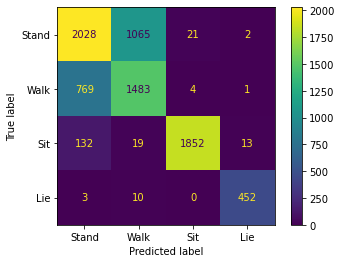

In [8]:
# Confusion Matrix
cm = metrics.confusion_matrix(y_test, uy_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp = disp.plot()

#plt.savefig('confusion_matricies/c4_f9(RLA)_km11.png') # number of classes, features, method
plt.show()